In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from skimage.io import imread, imshow,show, imsave
import copy

In [2]:
def compare_coords(coords_list, coord):
    if coord in coords_list:
        return True
    else:
        return False

In [3]:
#0 = 'ground'
#1 = 'wall'
#2 = 'bomb'
#3 'solid'
#4 "player_occupied"
#5 about_to_explode
#6 bomb_fire
class Block():
    def __init__(self, b_type,x_p, y_p):
        self.b_type=b_type
        self.x_p = x_p# x position
        self.y_p = y_p# y position
        self.b_power = 1 # bomb_power
        self.exploding = False
        self.explosion_counter = 2
        self.created_by = ''
    def __repr__(self): 
        return ('Type: {} [x:{} y:{}] '.format(str(self.b_type),self.x_p ,self.y_p)   )
    
    
    def explode(self, terrain_instance, players):
        self.exploding = True
        for b in terrain_instance.grab_all_blocks():
            
            if  b.capture_position() in [[self.x_p+self.b_power,self.y_p ],
                                       [self.x_p-self.b_power, self.y_p],
                                       [self.x_p, self.y_p+self.b_power],
                                       [self.x_p,self.y_p-self.b_power]]:
                
                if b.b_type == 1 or b.b_type == 0: #wall or ground
                    b.remove_this_block()
                    #print(b, 'removing...')
                if b.b_type == 2 and b.exploding==False: #bomb 
                    b.explode(terrain_instance, players)
                if b.b_type == 5 and b.exploding==False: #bomb about to explode
                    b.explode(terrain_instance, players)
        
                
            
            
        for pp in players:
            
            if  pp.get_my_position() in [[self.x_p+self.b_power,self.y_p ],
                                       [self.x_p-self.b_power,self.y_p],
                                       [self.x_p, self.y_p+self.b_power],
                                       [self.x_p,self.y_p-self.b_power]]:
                 
                
                
                pp.set_game_over()
                
                #print (pp.name, 'GAMEOVER')
        
        self.explosion_counter = 2
        self.created_by = ''
        self.remove_this_block() 
        #print ('BOM!')
                
    def remove_this_block(self):
        self.b_type=0  

    def capture_position(self):
        return [self.x_p, self.y_p]
        
    

In [4]:
class Terrain:
    def __init__(self, dim):
        self.dim  = dim
        self.terrain_values = [[Block( b_type=0,x_p=x, y_p=y) for y in range(self.dim)]  for x in range(self.dim)] # creating dim and ground
        self.creating_solid_structure_border() # creating basic borders 
        self.creating_random_destructibe_tyles() # creating Random
        
    def creating_solid_structure_border(self):      
        for r_x in range(self.dim):
            for r_y in range(self.dim):
                if r_x==0 or r_x==(self.dim-1) or r_y==0 or r_y==(self.dim-1)   :
                    self.terrain_values[r_x][r_y] = Block(b_type=3, x_p=r_x, y_p=r_y)
                      
    def return_block_by_coord(self, x, y):
        return self.terrain_values[x][y]
    
    def grab_all_block_in_a_class(self, class_id):

        return [b_x for b in self.terrain_values for b_x in b if b_x.b_type == class_id]
    
    def grab_all_blocks(self):

        return [b_x for b in self.terrain_values for b_x in b]
    
    def creating_random_destructibe_tyles(self):
        all_ground = self.grab_all_block_in_a_class(0)
        for b_random in all_ground:
            
            random_n = np.random.choice([0,1], p=[0.4, 0.6])
            #print (random_n)
            b_random.b_type = random_n
    
    def trimming_corns(self):
        pass
        #TRIMAR CANTOS
        #COLOCA TUDO 0 E ESCOLHE UM RANDOM PREENCHIDO
    
    def get_all_positions_inside_a_cross(self, x_v, y_v):
        return dict(zip('UP DOWN LEFT RIGHT CENTER'.split(), [self.return_block_by_coord(x_v,y_v +1),
                                                              self.return_block_by_coord(x_v, y_v-1),
                                                              self.return_block_by_coord(x_v-1, y_v),
                                                              self.return_block_by_coord(x_v+1,y_v),
    
                                                              self.return_block_by_coord(x_v,y_v)]))    
    def show_terrain(self,):  
        sns.heatmap(np.array([[y_show.b_type for y_show in x_show] for x_show in self.terrain_values]), cmap='tab10')

        plt.show()
        
    def render_terrain(self, fig_name=None):    
        blocks_it = iter([t.b_type  for t in self.grab_all_blocks()])
        full_scenario = np.concatenate([  np.concatenate([ dict_sprites[blocks_it.next()] for y in range(self.dim )]) for x in range(self.dim )],axis=1)
        imshow(full_scenario)
        if fig_name:
            imsave(fig_name, full_scenario)
        show()
        
        
    def capture_encoded_map(self):
        return ( ''.join([ str(y_show.b_type) for x_show in self.terrain_values  for y_show in x_show]))
    
    def return_number_of_blocks_to_destruct(self):
        return float(len(self.grab_all_block_in_a_class(1)))
    
        
class CPU():
    def __init__(self,name, x_p, y_p, terrain):
        self.GAMEOVER=False
        self.name = name
        self.terrain = terrain
        self.x_p = x_p 
        self.y_p = y_p
        self.n_used_bombs = 0
        self.max_bomb = 1
        self.terrain.return_block_by_coord(self.x_p, self.y_p).b_type = 4
        
    def check_free_space(self):
        all_possible_empty =  {k:v for k,v in self.terrain.get_all_positions_inside_a_cross(self.x_p, self.y_p).iteritems() if v.b_type<2 and k!= 'CENTER' }
        #all_possible_empty =  self.terrain.get_all_positions_inside_a_cross(self.x_p, self.y_p)
        return all_possible_empty
    
    def add_bomb(self, x_b, y_b):
        self.terrain.return_block_by_coord(x_b, y_b).b_type=2
        self.terrain.return_block_by_coord(x_b, y_b).created_by=self.name
        self.n_used_bombs =+ 1 
    def get_my_position(self):
        return  [self.x_p, self.y_p]
    
    
    def move_to_position(self, x_m, y_m):
        self.terrain.return_block_by_coord(self.x_p, self.y_p).b_type = 0 #old position
        self.x_p = x_m 
        self.y_p = y_m
        self.terrain.return_block_by_coord(x_m, y_m).b_type = 4 # new position
        
    def set_game_over(self):
        self.terrain.return_block_by_coord(self.x_p, self.y_p).b_type = 0#old position   
        self.GAMEOVER = True
     
    def bomb_in_game(self):
        out=False
        if self.name in {b.created_by for b in self.terrain.grab_all_block_in_a_class(2)}:
                out=True
        return out
        
    def perform_possible_actions_by_index(self, action):
        if action == 'UP':
            self.move_to_position(self.x_p, self.y_p+1)
        if action == 'DOWN':
            self.move_to_position(self.x_p, self.y_p-1)
        if action == 'LEFT':
            self.move_to_position(self.x_p-1, self.y_p)
        if action == 'RIGHT':
            self.move_to_position(self.x_p+1, self.y_p)  
        if action == 'NO_ACTION':
            pass     
        if action == 'B_UP':
            self.add_bomb(self.x_p, self.y_p+1)
        if action == 'B_DOWN':
            self.add_bomb(self.x_p, self.y_p-1)
        if action == 'B_LEFT':
            self.add_bomb(self.x_p-1, self.y_p)
        if action == 'B_RIGHT':
            self.add_bomb(self.x_p+1, self.y_p)  

    def capture_posible_actions(self):
        vector_free_spaces = self.check_free_space()
        return_actions = []
        #UP DOWN LEFT RIGHT CENTER
        if 'UP' in vector_free_spaces:
            return_actions.append('UP')
        if 'UP' in vector_free_spaces and not self.bomb_in_game():
            return_actions.append('B_UP')
        if 'DOWN' in vector_free_spaces:
            return_actions.append('DOWN')
        if 'DOWN' in vector_free_spaces and not self.bomb_in_game():
            return_actions.append('B_DOWN')
        if 'LEFT' in vector_free_spaces:
            return_actions.append('LEFT')
        if 'LEFT' in vector_free_spaces and not self.bomb_in_game():
            return_actions.append('B_LEFT')    
        if 'RIGHT' in vector_free_spaces:
            return_actions.append('RIGHT')
        if 'RIGHT' in vector_free_spaces and not self.bomb_in_game():
            return_actions.append('B_RIGHT')
        
        
        return return_actions + ['NO_ACTION']
    

In [5]:
actions_hash_to_numbers = {'UP':0,
'DOWN':1,
'LEFT':2,
'RIGHT':3,
'NO_ACTION':4,
'B_UP':5,
'B_DOWN':6,
'B_LEFT':7,
'B_RIGHT':8}


In [6]:
#random.sample(['a', 'b', 'c'],1)

In [7]:

class TileSet():
    def __init__(self, img_path):
        self.im = imread(img_path, key=0)
        self.memory_sprites_dict = self.load_sprites_in_memory()
    def show(self):
        imshow(self.im)
        show()
    def load_sprites_in_memory(self):
        sprites = {}
        for n_x,x in enumerate(range(0,255,32)) :
            for n_y,y in enumerate(range(0,255,32)) :
                sprites['{}_{}'.format(str(n_x), str(n_y))] = self.im[x:x+32, y : y+32 ]
        return sprites
    def get_img_by_index(self, x,y):
        return self.memory_sprites_dict['{}_{}'.format(str(x),str(y))]
    def show_img_by_index(self, x,y):
        imshow(self.memory_sprites_dict['{}_{}'.format(str(x),str(y))])
        
        
        
scenario = TileSet('B3.png')
dict_sprites = dict(zip([0,1,2,3,4,5,6], [
                scenario.get_img_by_index(7,2),
                scenario.get_img_by_index(6,0),
                scenario.get_img_by_index(3,3),
                scenario.get_img_by_index(5,6),
                scenario.get_img_by_index(0,0),
                scenario.get_img_by_index(3,4),
                scenario.get_img_by_index(7,3)]))



In [8]:
(1-7.0 /10)

0.30000000000000004

In [9]:

class GameLoop():
    def __init__(self, players, terrain_map):
        self.players = players
        self.terrain_map = terrain_map
        self.Turn = 1
        self.episode_count=0
        self.initial_number_of_blocks_to_destruct = self.terrain_map.return_number_of_blocks_to_destruct()
        self.GAMEOVERLOOP = False
        self.show_game = False
        self.last_reward = None
        self.value_before = self.terrain_map.return_number_of_blocks_to_destruct() 
        self.after = self.terrain_map.return_number_of_blocks_to_destruct() 
    def get_reward(self):
        if (self.value_after) > 0:
            r =  (self.value_after**2) * (1 - (self.Turn / round(100))) 
            #print ('block:',r)
        else:
            
            r = -1 * (self.Turn / round(100))
            #print ('noblock',r)
        return r
    
    def get_state(self):
        return game.terrain_map.capture_encoded_map()
    
    
    def start_loop(self):
        LEARNING_RATE = 0.5
        DISCOUNT = 0.98
        global q_hash
        global EPISLON
        for t in  range(100):
            if not self.GAMEOVERLOOP:

                self.solve_bombs() # solve the bomb explosions 
                if self.show_game:
                    self.terrain_map.render_terrain("figures/{}_epi_{}_turn_flash_{}_bl.png".format(str(self.episode_count), str(t), str(0) ))
                state = self.get_state()
                if state not in q_hash:
                    q_hash[state] = np.random.uniform(0, 0 ,9)
                #print ('Turn', t)
                #print (q_hash[state])

    

                possible_actions = self.players[0].capture_posible_actions()
                actions_and_index = [[actions_hash_to_numbers[a],a] for a in possible_actions]
                actions_and_values = [[ q_hash[state] [actions_hash_to_numbers[a]],
                                       actions_hash_to_numbers[a],
                                       a] for a in possible_actions]

                best_moviment = max(actions_and_values)
                #print (best_moviment)
                
                
                if np.random.random() < EPISLON:
                    random_action  = random.sample(possible_actions, 1)[0]
                    best_moviment[0] = q_hash[state] [actions_hash_to_numbers[random_action]]
                    best_moviment[1] = actions_hash_to_numbers[random_action]
                    best_moviment[2] = random_action
                    
                    
                     
                self.players[0].perform_possible_actions_by_index(best_moviment[2])   
                self.value_before = self.terrain_map.return_number_of_blocks_to_destruct() 

                
                self.solve_bombs() # solve the bomb explosions 
                
                if self.show_game:
                    self.terrain_map.render_terrain("figures/{}_epi_{}_turn_flash_{}_bl.png".format(str(self.episode_count), str(t), str(1) ))
                
                self.value_after = self.value_before - self.terrain_map.return_number_of_blocks_to_destruct()
                if self.show_game:
                    #self.terrain_map.show_terrain()
                    self.terrain_map.render_terrain("figures/{}_epi_{}_turn_flash_{}_bl.png".format(str(self.episode_count), str(t), str(2) ))
                    
                    
                if not self.players[0].GAMEOVER:
                
                    
                    reward = self.get_reward()
                
                
                    future_state = self.get_state()
                    if future_state not in q_hash:
                        q_hash[future_state] = np.random.uniform(0, 0 ,9)
                                                       
                    future_possible_actions = self.players[0].capture_posible_actions()
                    future_actions_and_index = [[actions_hash_to_numbers[a],a] for a in future_possible_actions]
                    future_actions_and_values = [[ q_hash[future_state] [actions_hash_to_numbers[a]],
                                           actions_hash_to_numbers[a],
                                           a] for a in future_possible_actions]




                    max_future = max(actions_and_values)[0] # max future reward
                    action_current_q = best_moviment[0]
                    (q_hash[state])[best_moviment[1]] = action_current_q +  LEARNING_RATE * (reward + (DISCOUNT * max_future)- action_current_q ) 
                    
                    

                    

                    #find the posible actions
                    #extract before get the most important action


                    #PLAYER ACTIONS
                    ##ONE PLAYER PER TURN
                    self.last_reward = reward
                    
                    
                    
                    
                else:
                    (q_hash[state])[best_moviment[1]] = (q_hash[state])[best_moviment[1]]   - 100 # update case explode
                    
                    self.GAMEOVERLOOP=True
                    #print ('end')
                
                if  self.terrain_map.return_number_of_blocks_to_destruct() == 0:
                    self.GAMEOVERLOOP=True
                
                self.Turn += 1
                
        
    def solve_bombs(self):
        for bomb in self.terrain_map.grab_all_block_in_a_class(5):
            if bomb.explosion_counter== 0 :
                bomb.explode(self.terrain_map, self.players)
        for bomb in self.terrain_map.grab_all_block_in_a_class(2):
            bomb.explosion_counter -=1
            if bomb.explosion_counter == 0:
                bomb.b_type=5
    
#         for bomb_fire in self.terrain_map.grab_all_block_in_a_class(6):
#             if bomb_fire.bomb_fire == 0:
#                 bomb_fire.b_type=1
#             if bomb_fire.bomb_fire == 1:
#                 bomb_fire.bomb_fire =0
                

(q_hash[state])[best_moviment[1]] = action_current_q +  (LEARNING_RATE * (reward + (DISCOUNT * max_future)- action_current_q ) ) 




The last term __ 
 - action_current_q

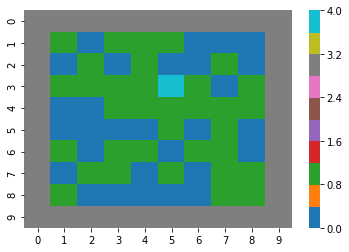

In [10]:
np.random.seed(1000)
T_unique = Terrain(10)

T= copy.deepcopy(T_unique)
cpu1 = CPU('CPU_1', 3, 5, T)

T.show_terrain()

# Fixing just one T sample

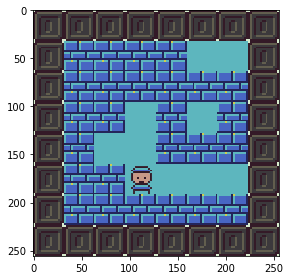

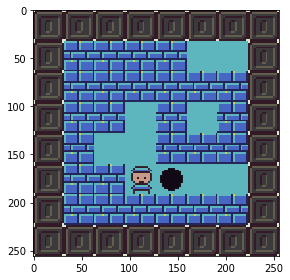

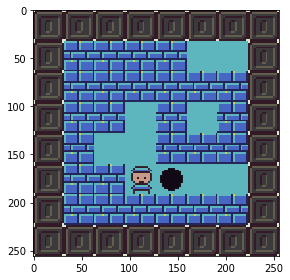

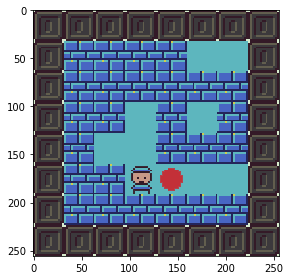

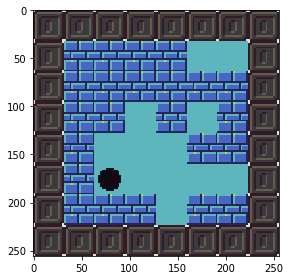

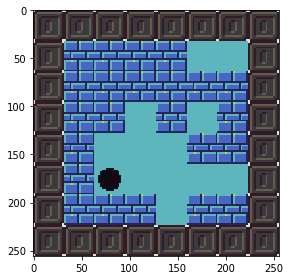

/Users/lxf453/miniconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lxf453/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0, 0.1, 'Number of turns:', 3, 'mean blocks to win:', nan)
(2000, 0.098, 'Number of turns:', 9, 'mean blocks to win:', 20.514)
(4000, 0.096, 'Number of turns:', 18, 'mean blocks to win:', 19.47)
(6000, 0.094, 'Number of turns:', 17, 'mean blocks to win:', 18.272)
(8000, 0.092, 'Number of turns:', 36, 'mean blocks to win:', 17.6025)
(10000, 0.09, 'Number of turns:', 15, 'mean blocks to win:', 16.073)
(12000, 0.088, 'Number of turns:', 19, 'mean blocks to win:', 14.4605)
(14000, 0.086, 'Number of turns:', 26, 'mean blocks to win:', 12.9395)
(16000, 0.084, 'Number of turns:', 37, 'mean blocks to win:', 11.9345)
(18000, 0.082, 'Number of turns:', 18, 'mean blocks to win:', 11.5045)


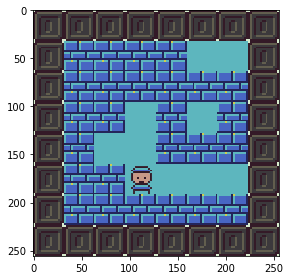

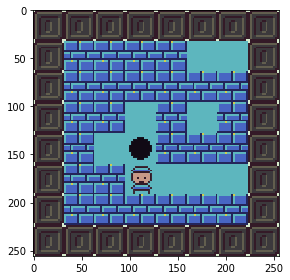

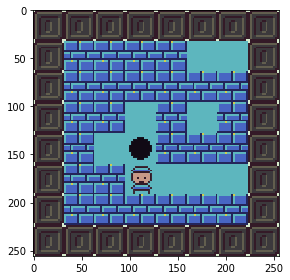

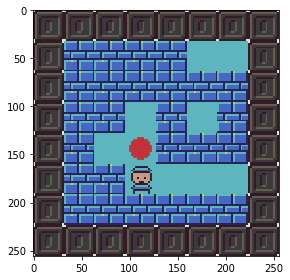

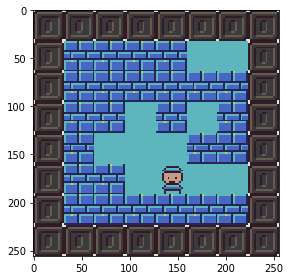

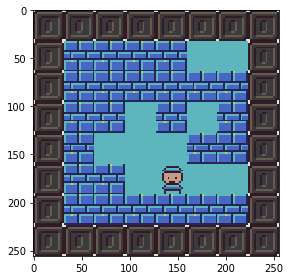

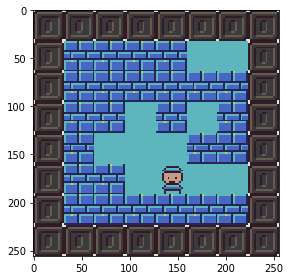

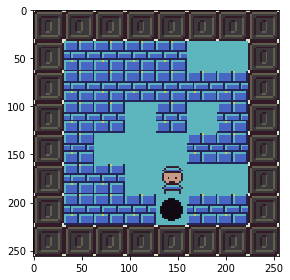

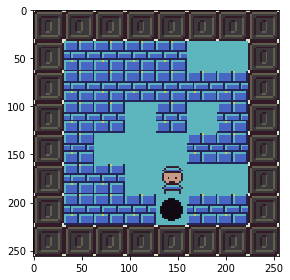

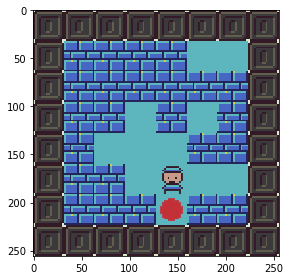

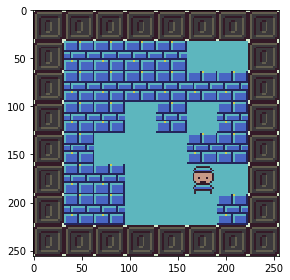

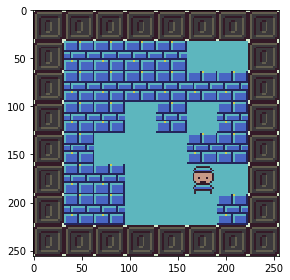

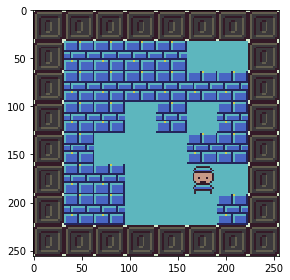

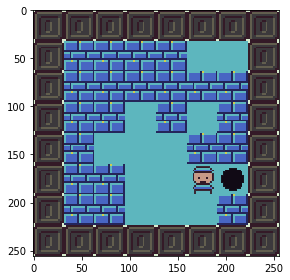

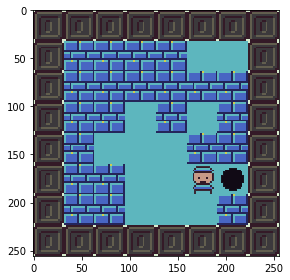

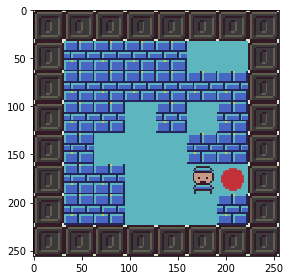

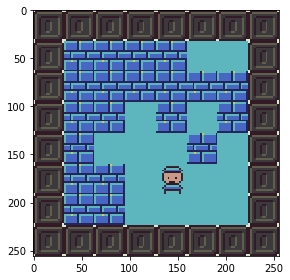

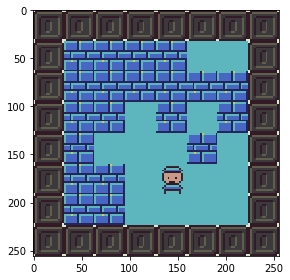

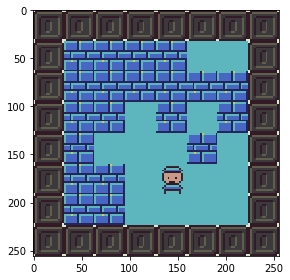

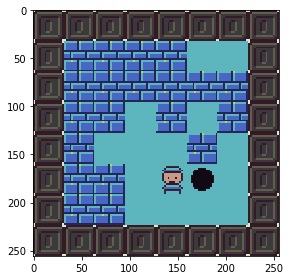

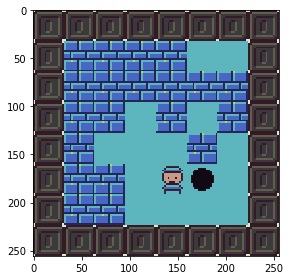

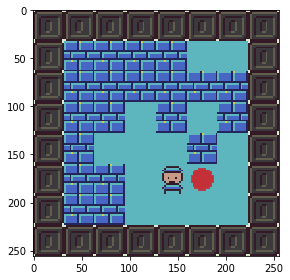

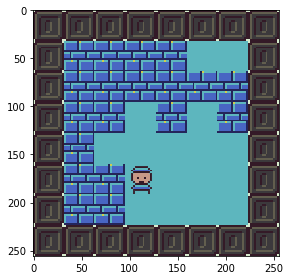

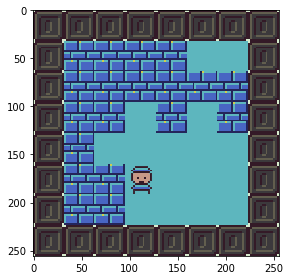

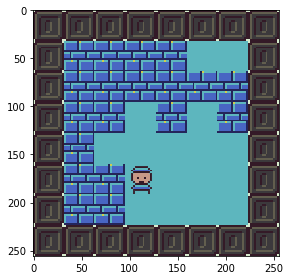

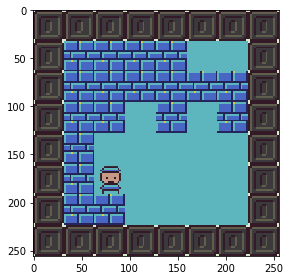

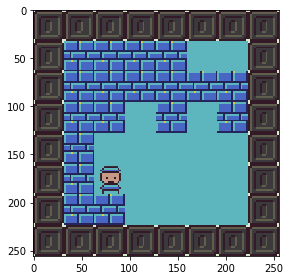

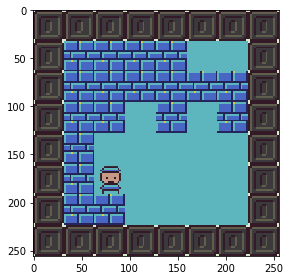

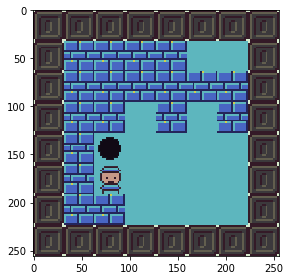

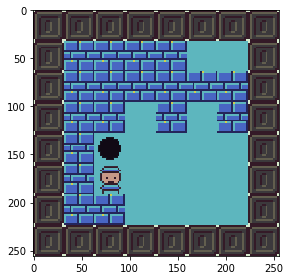

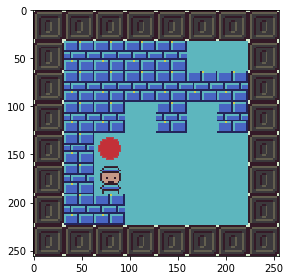

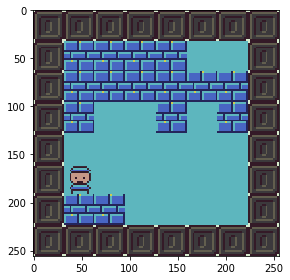

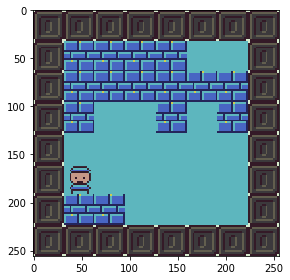

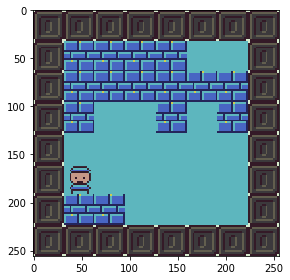

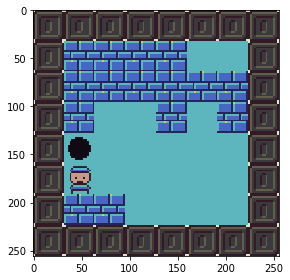

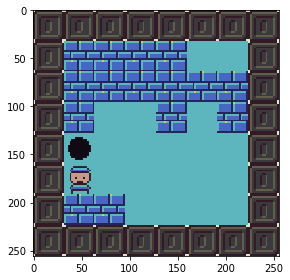

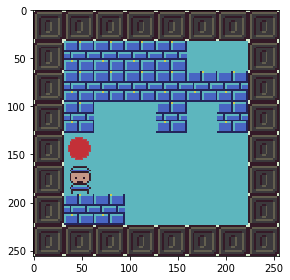

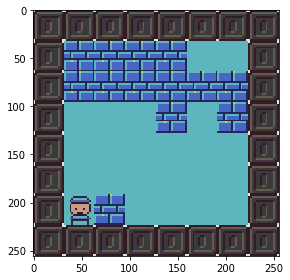

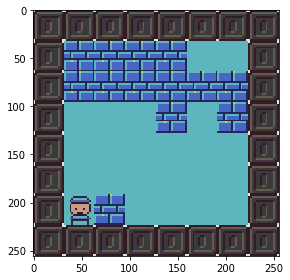

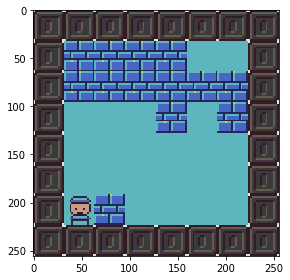

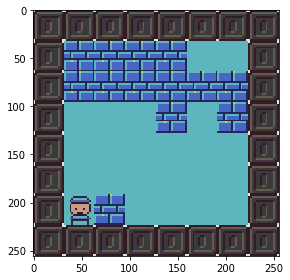

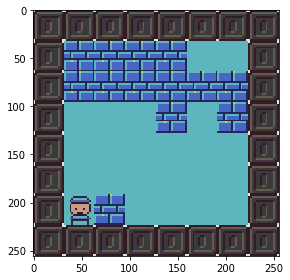

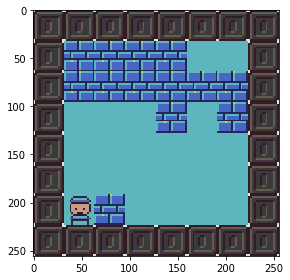

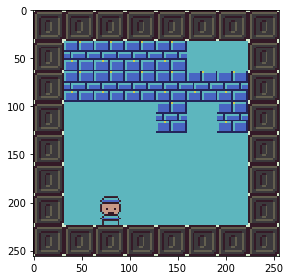

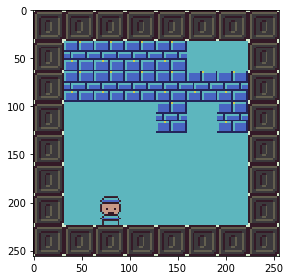

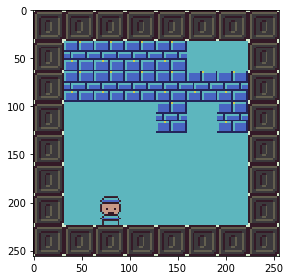

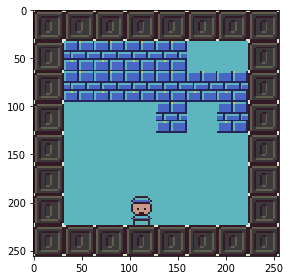

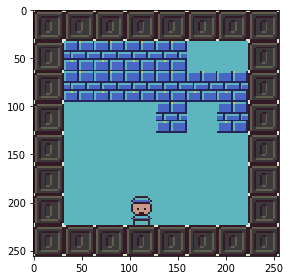

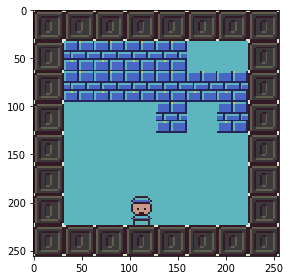

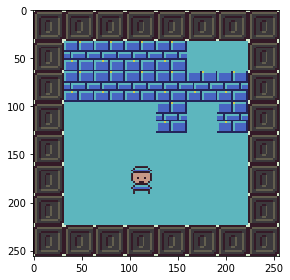

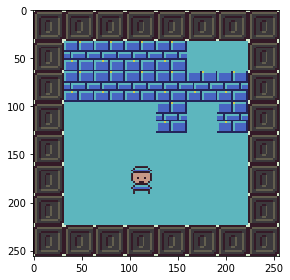

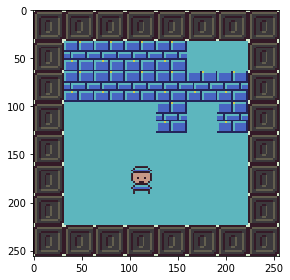

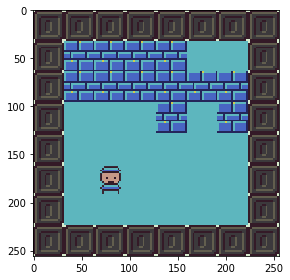

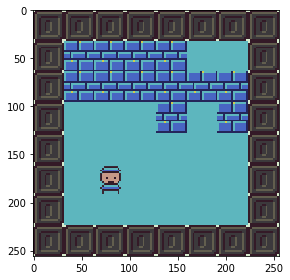

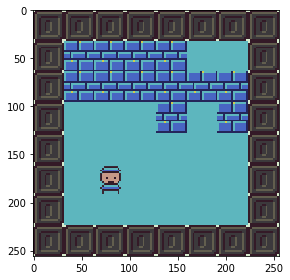

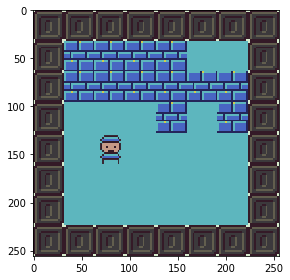

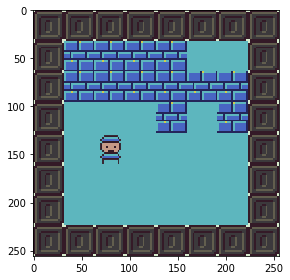

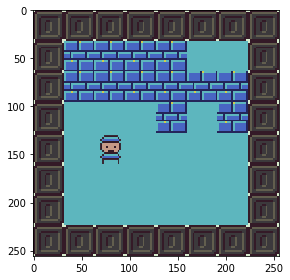

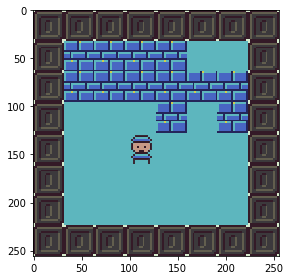

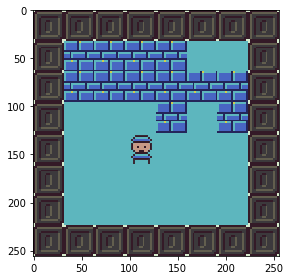

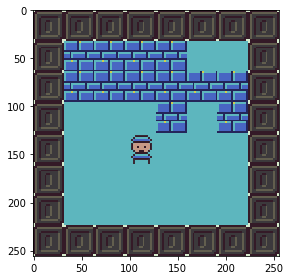

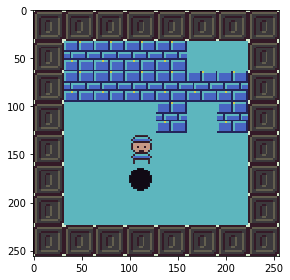

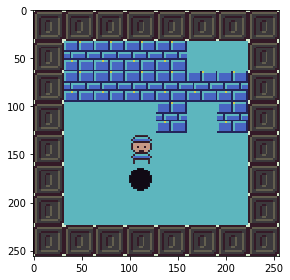

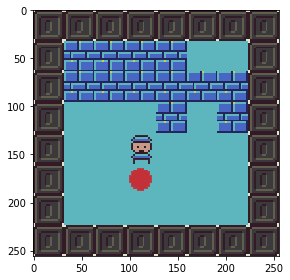

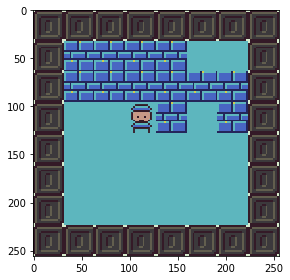

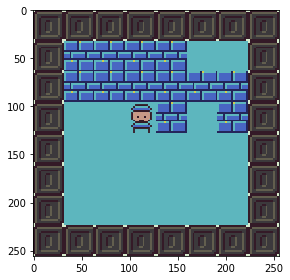

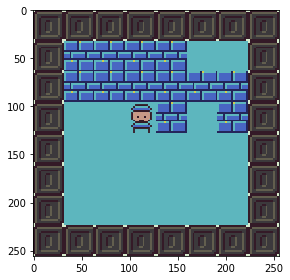

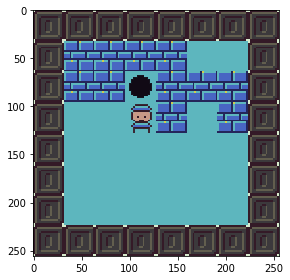

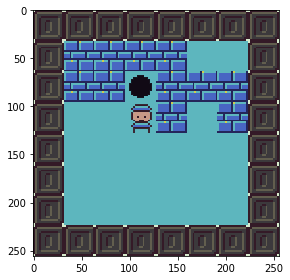

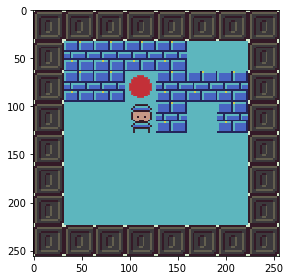

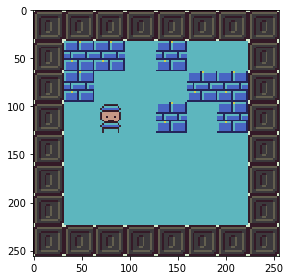

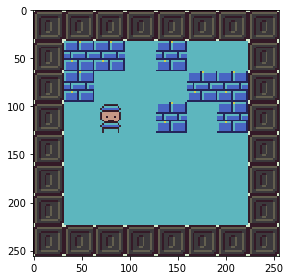

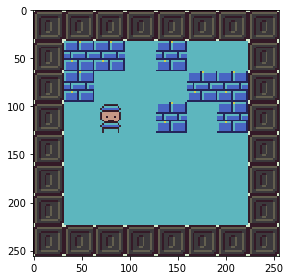

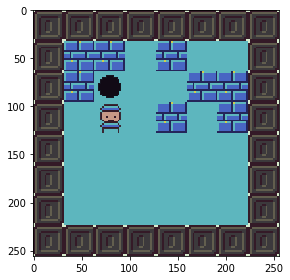

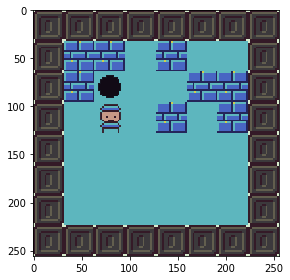

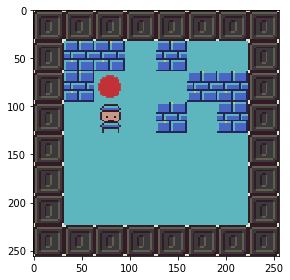

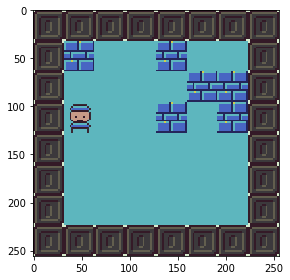

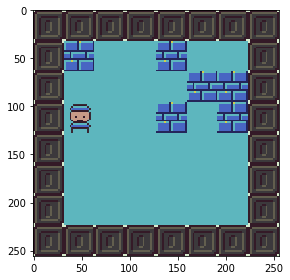

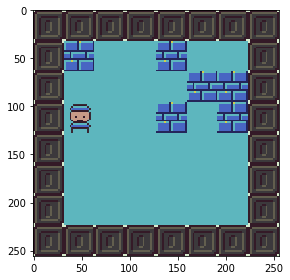

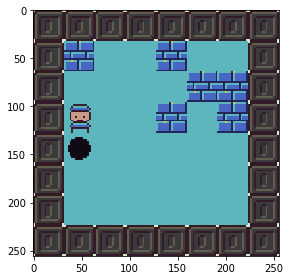

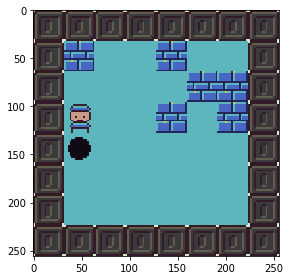

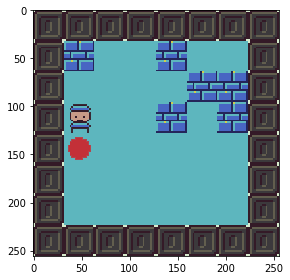

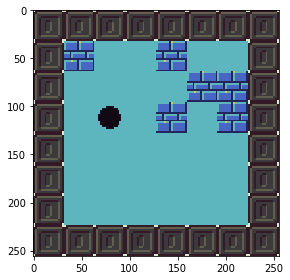

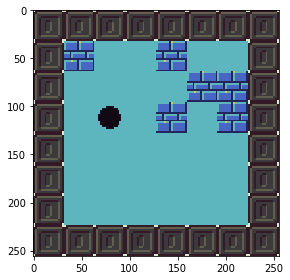

(20000, 0.08, 'Number of turns:', 29, 'mean blocks to win:', 11.375)


In [ ]:
q_hash = {}
EPISLON=0.1
mean_score = []
for episode in range(10000000):
    np.random.seed(0)
    T = Terrain(8)
    np.random.seed(np.random.randint(10000))
    cpu1 = CPU('CPU_1', 3, 5, T)
    T.return_block_by_coord (4,5).b_type = 0
    T.return_block_by_coord (5,5).b_type = 0 
    game = GameLoop([cpu1], T)
    if (episode % 20000) == 0:
        game.episode_count = episode
        game.show_game =True
    game.start_loop()
    
    if (episode % 2000) == 0:
        
        print (episode,
               np.round(EPISLON, 5),
               'Number of turns:',game.Turn,
               'mean blocks to win:', np.mean(mean_score))
        mean_score = []
    EPISLON -= 0.000001
    mean_score.append(game.terrain_map.return_number_of_blocks_to_destruct())

In [ ]:
q_hash

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)


# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)


HTML(anim.to_html5_video())

## Number of states

In [ ]:
q_hash

In [ ]:
#game.terrain_map.return_number_of_blocks_to_destruct()

In [236]:
#scenario.show_img_by_index(3,4)

In [ ]:
#0 = 'ground' # scenario.show_img_by_index(7,5)
#1 = 'wall' # scenario.show_img_by_index(6,0)
#2 = 'bomb' # scenario.show_img_by_index(3,3)
#3 'solid' # scenario.show_img_by_index(5,6)
#4 "player_occupied"  # scenario.show_img_by_index(0,0)
#5 about_to_explode # scenario.show_img_by_index(3,4)

In [265]:
dict_sprites = dict(zip([0,1,2,3,4,5], [scenario.get_img_by_index(7,5),
                scenario.get_img_by_index(6,0),
                scenario.get_img_by_index(3,3),
                scenario.get_img_by_index(5,6),
                scenario.get_img_by_index(0,0),
                scenario.get_img_by_index(3,4)]))

blocks_it = iter([t.b_type  for t in T.grab_all_blocks()])
full_scenario = np.concatenate([  np.concatenate([ dict_sprites[blocks_it.next()] for y in range(10)]) for x in range(10)],axis=1)
imshow(full_scenario)